In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2
import warnings
warnings.filterwarnings('ignore')

# Dataset 

In [2]:
print(f"axial_train: {len(os.listdir('axial_MRI/train')) - 1}")
print(f"axial_val: {len(os.listdir('axial_MRI/valid')) - 1}")
print(f"axial_test: {len(os.listdir('axial_MRI/test')) - 1}")

axial_train: 253
axial_val: 79
axial_test: 39


In [3]:
bbox = pd.read_csv('axial_MRI/train/_annotations.csv')

bbox.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,00254_83_jpg.rf.dc8444a939bfda955ec3a0ef668b5c...,192,256,positive,50,105,77,143
1,00305_113_jpg.rf.da8b7d0769c01e94571b568186f33...,256,256,positive,150,91,167,106
2,00097_80_jpg.rf.e31f89dee132f5da82d5e3c3fc0125...,256,256,negative,160,151,192,186
3,00099_154_jpg.rf.d9eb261c8c610b762f46f1e6f7cfc...,256,256,negative,90,187,107,205
4,00240_134_jpg.rf.dacd6bdae9ee803c1eed41507c352...,192,256,positive,85,97,106,126


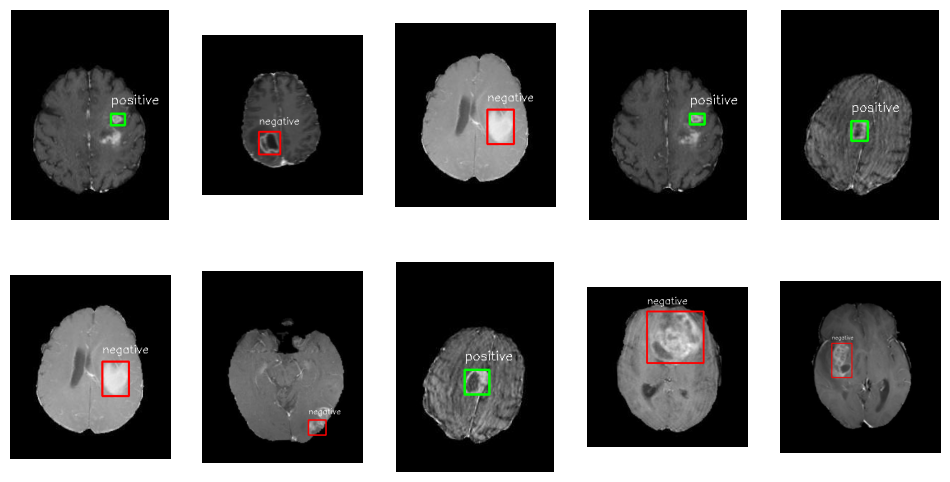

In [15]:
import random

figure = plt.figure(figsize=(12, 6)) 

row, col = 2, 5

r = random.randint(1, len(bbox))

for i in range(10):
    r = random.randint(1, len(bbox))
    value = bbox.values[r]
    img_name = value[0]
    color = (0, 255, 0) if value[3] == 'positive' else (255, 0, 0)
    txt = 'positive' if value[3] == 'positive' else 'negative'
    box = value[4:].astype('int')
    img = cv2.imread(f'axial_MRI/train/{img_name}')
    pt1 = box[0], box[1]
    pt2 = box[2], box[3]
    cv2.rectangle(img, pt1, pt2, color, 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_size, _ = cv2.getTextSize(txt, font, font_scale, thickness)
    x, y = pt1
    text_x = x
    text_y = y - text_size[1]
    cv2.putText(img, txt, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)
    figure.add_subplot(row, col, i+1)
    plt.axis("off")
    plt.imshow(img)

# Selective Search

num_regional proposal: 86


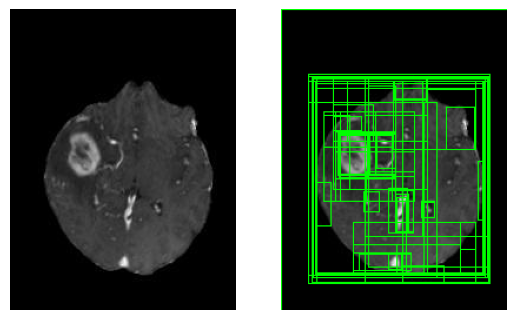

In [61]:
img = cv2.imread(f'axial_MRI/train/{bbox.values[0][0]}')

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
ss.setBaseImage(img) 
ss.switchToSelectiveSearchFast() 
rects = ss.process()

for rect in rects:
    x, y, w, h = rect
    img_out = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_out)
print(f'num_regional proposal: {len(rects)}')

In [69]:
from regional_proposal import selective_search_

cv2.setUseOptimized(True) 
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 

up_threshold = 0.6
down_threshold = 0.3

threshold = (up_threshold, down_threshold)
positive_sample = []
negative_sample = []

for value in bbox.values:
    name = value[0]
    img = cv2.imread(f'axial_MRI/train/{name}')
    gtbox = bbox[bbox.filename == name].values[0][4:].astype('int')
    gtbb = {
            'x1': gtbox[0],
            'y1': gtbox[1],
            'x2': gtbox[2],
            'y2': gtbox[3]
           }
    pos, neg = selective_search_(ss, img, gtbb, threshold)
    positive_sample += pos
    negative_sample += neg

len(positive_sample), len(negative_sample)

(1311, 25985)

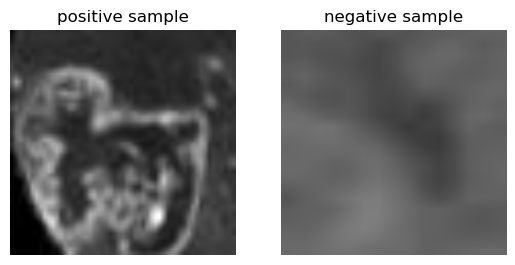

In [70]:
import random

r1 = random.randint(1, len(positive_sample) + 1)
r2 = random.randint(1, len(negative_sample) + 1)

plt.subplot(1, 2, 1)
plt.imshow(positive_sample[r1])
plt.axis('off')
plt.title('positive sample')

plt.subplot(1, 2, 2)
plt.imshow(negative_sample[r2])
plt.axis('off')
plt.title('negative sample')
plt.show()

In [81]:
import imgaug.augmenters as iaa

aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(gamma=(0.5, 2.0)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
])

augmented_positive_sample = []

for idx, image in enumerate(positive_sample):
    img = image
    for j in range(20):
        augmented_img = aug_pipeline(image=img)
        augmented_positive_sample.append(augmented_img)

len(augmented_positive_sample), len(negative_sample)

(26220, 25985)

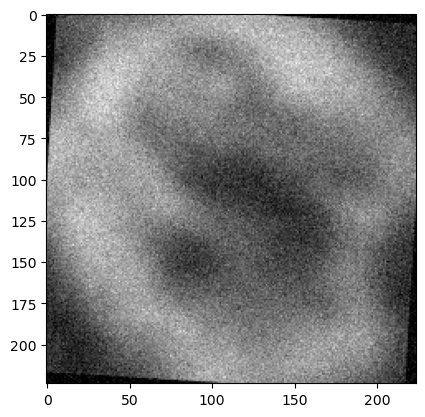

In [84]:
for img in augmented_positive_sample:
    img = 

# model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [ ]:
import torch.nn as nn
import torch.utils.data.Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
])

class ROINet(Dataset): 
    def __init__(self, positive_sample, negative_sample):
        self.images = positive_sample + negative_sample

In [89]:
!pip install torch torchvision --upgrade

In [90]:
a = np.random.randint(256, size=(3, 3, 3))
import torchvision.transforms as transforms

transforms.ToTensor(a)
a

ImportError: cannot import name '_log_api_usage_once' from 'torchvision.utils' (/opt/anaconda3/lib/python3.9/site-packages/torchvision/utils.py)